The objective of this module: join together a few datasets of nursing home information  

Eventual goal:  
Try to predict nursing homes relative infection and/or readmittance rates  

In [1]:
import pandas as pd
import numpy as np

In [2]:
#load Health Deficiencies - https://data.cms.gov/provider-data/dataset/r5ix-sfxw
citationsDF = pd.read_csv('datasets/NH_HealthCitations_Jan2023.csv', dtype = {'Federal Provider Number' : str})
citationsDF.columns = citationsDF.columns.str.replace(' ', '')

#load Penalties - https://data.cms.gov/provider-data/dataset/g6vv-u9sr
penaltysDF = pd.read_csv('datasets/NH_Penalties_Jan2023.csv')
penaltysDF.columns = penaltysDF.columns.str.replace(' ', '')

#load Medicare Claims Quality Measures - https://data.cms.gov/provider-data/dataset/ijh5-nb2v
medicareClaimsDF = pd.read_csv('datasets/NH_QualityMsr_Claims_Jan2023.csv')
medicareClaimsDF.columns = medicareClaimsDF.columns.str.replace(' ', '')

#load MDS Quality Measures - https://data.cms.gov/provider-data/dataset/djen-97ju
residentAssessmentDF = pd.read_csv('datasets/NH_QualityMsr_MDS_Jan2023.csv', dtype = {'Federal Provider Number': str})
residentAssessmentDF.columns = residentAssessmentDF.columns.str.replace(' ', '')

#load Skilled Nursing Facility Quality Reporting Program - Provider Data - https://data.cms.gov/provider-data/dataset/fykj-qjee
careMeasuresDF = pd.read_csv('datasets/Skilled_Nursing_Facility_Quality_Reporting_Program_Provider_Data_Jan2023.csv' , dtype = {'CMS Certification Number (CCN)': str})
careMeasuresDF.columns = careMeasuresDF.columns.str.replace(' ', '')


We will be predicting which facilities are likely to perform above, below, or at the national rate for returning people home from a skilled nursing facility

We can see that most facilities perform about the same, with 5517 no value entries

In [3]:
careMeasuresDF.loc[careMeasuresDF["MeasureCode"] == "S_005_02_DTC_COMP_PERF"].Score.value_counts()

No Different than the National Rate    7224
Not Available                          5517
Better than the National Rate          1787
Worse than the National Rate            579
Name: Score, dtype: int64

Alternatively, we could predict which facilities are above, below, or at the national rate for residents aquiring infections which require hospitalization

In [4]:
careMeasuresDF.loc[careMeasuresDF["MeasureCode"] == "S_039_01_HAI_COMP_PERF"].Score.value_counts()

No Different than the National Rate    11255
Not Available                           3209
Worse than the National Rate             473
Better than the National Rate            170
Name: Score, dtype: int64

There is also a score for the rate of facilities rate of preventable hospital readmission, but as seen below, there is an uneven enough class distribution as to make predicting anything seem unreasonable

In [5]:
careMeasuresDF.loc[careMeasuresDF["MeasureCode"] == "S_004_01_PPR_PD_COMP_PERF"].Score.value_counts()

No Different than the National Rate    11346
Not Available                           3745
Worse than the National Rate              16
Name: Score, dtype: int64

We can start off by getting a look at the data and trying to figure out what data we want to keep from each table.
Going in order one at a time we start with the citations table.

In [6]:
citationsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381238 entries, 0 to 381237
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   FederalProviderNumber                 381238 non-null  object
 1   ProviderName                          381232 non-null  object
 2   ProviderAddress                       381238 non-null  object
 3   ProviderCity                          381238 non-null  object
 4   ProviderState                         381238 non-null  object
 5   ProviderZipCode                       381238 non-null  int64 
 6   SurveyDate                            381238 non-null  object
 7   SurveyType                            381238 non-null  object
 8   DeficiencyPrefix                      381238 non-null  object
 9   DeficiencyCategory                    381238 non-null  object
 10  DeficiencyTagNumber                   381238 non-null  int64 
 11  DeficiencyDes

In [7]:
citationsDF.head()

,FederalProviderNumber,ProviderName,ProviderAddress,ProviderCity,ProviderState,ProviderZipCode,SurveyDate,SurveyType,DeficiencyPrefix,DeficiencyCategory,...,DeficiencyCorrected,CorrectionDate,InspectionCycle,StandardDeficiency,ComplaintDeficiency,InfectionControlInspectionDeficiency,CitationunderIDR,CitationunderIIDR,Location,ProcessingDate
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2019-08-21,Health,F,Resident Rights Deficiencies,...,"Deficient, Provider has date of correction",2019-09-16,1,Y,N,N,N,N,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2023-01-01
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2019-08-21,Health,F,Infection Control Deficiencies,...,"Deficient, Provider has date of correction",2019-09-16,1,Y,N,N,N,N,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2023-01-01
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2018-08-01,Health,F,Infection Control Deficiencies,...,"Deficient, Provider has date of correction",2018-09-05,2,Y,N,N,N,N,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2023-01-01
3,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,2019-06-13,Health,F,Infection Control Deficiencies,...,"Deficient, Provider has date of correction",2019-07-17,2,Y,N,N,N,N,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2023-01-01
4,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,2018-06-07,Health,F,Resident Assessment and Care Planning Deficien...,...,"Deficient, Provider has date of correction",2018-07-12,3,Y,N,N,N,N,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2023-01-01


In [8]:
citationsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381238 entries, 0 to 381237
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   FederalProviderNumber                 381238 non-null  object
 1   ProviderName                          381232 non-null  object
 2   ProviderAddress                       381238 non-null  object
 3   ProviderCity                          381238 non-null  object
 4   ProviderState                         381238 non-null  object
 5   ProviderZipCode                       381238 non-null  int64 
 6   SurveyDate                            381238 non-null  object
 7   SurveyType                            381238 non-null  object
 8   DeficiencyPrefix                      381238 non-null  object
 9   DeficiencyCategory                    381238 non-null  object
 10  DeficiencyTagNumber                   381238 non-null  int64 
 11  DeficiencyDes

In [9]:
citationsDF['FederalProviderNumber'].value_counts()

056078    162
056431    152
365499    148
215094    147
505202    146
         ... 
165335      1
45F937      1
165327      1
335373      1
335785      1
Name: FederalProviderNumber, Length: 15003, dtype: int64

In [10]:
citationCategories = ['StandardDeficiency', 'ComplaintDeficiency', 'InfectionControlInspectionDeficiency', 'CitationunderIDR', 'CitationunderIIDR']
citationsDF[citationCategories] = citationsDF[citationCategories].astype(str).replace('N', np.NaN)
citationsCounts = pd.DataFrame(citationsDF.groupby('FederalProviderNumber')[citationCategories].count())

In [11]:
citationsCounts

,StandardDeficiency,ComplaintDeficiency,InfectionControlInspectionDeficiency,CitationunderIDR,CitationunderIIDR
FederalProviderNumber,,,,,
015009,3,0,0,0,0
015010,5,0,0,0,0
015012,6,0,0,0,0
015014,9,0,0,0,0
015015,10,2,0,0,0
...,...,...,...,...,...
745000,0,2,1,0,0
745001,4,0,0,0,0
745002,8,0,0,0,0


In [12]:
citationsCounts.index.nunique()

15003

We now have 15003 unique identifiers, and our data is 15003 values long, so each identifier is unique
Now we move on to the next dataset

Now we can take a look at the penalties table

In [13]:
penaltysDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36516 entries, 0 to 36515
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FederalProviderNumber      36516 non-null  object 
 1   ProviderName               36516 non-null  object 
 2   ProviderAddress            36516 non-null  object 
 3   ProviderCity               36516 non-null  object 
 4   ProviderState              36516 non-null  object 
 5   ProviderZipCode            36516 non-null  int64  
 6   PenaltyDate                36516 non-null  object 
 7   PenaltyType                36516 non-null  object 
 8   FineAmount                 33907 non-null  float64
 9   PaymentDenialStartDate     2609 non-null   object 
 10  PaymentDenialLengthinDays  2609 non-null   float64
 11  Location                   36516 non-null  object 
 12  ProcessingDate             36516 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usa

In [14]:
penaltysDF.head()

,FederalProviderNumber,ProviderName,ProviderAddress,ProviderCity,ProviderState,ProviderZipCode,PenaltyDate,PenaltyType,FineAmount,PaymentDenialStartDate,PaymentDenialLengthinDays,Location,ProcessingDate
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2021-08-30,Fine,655.0,NaN,NaN,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2023-01-01
1,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,2020-08-31,Fine,650.0,NaN,NaN,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2023-01-01
2,015015,PLANTATION MANOR NURSING HOME,6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111,2021-02-08,Fine,650.0,NaN,NaN,"6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111",2023-01-01
3,015015,PLANTATION MANOR NURSING HOME,6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111,2021-06-28,Fine,975.0,NaN,NaN,"6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111",2023-01-01
4,015032,DIVERSICARE OF FOLEY,1701 NORTH ALSTON STREET,FOLEY,AL,36535,2021-06-04,Fine,20651.0,NaN,NaN,"1701 NORTH ALSTON STREET,FOLEY,AL,36535",2023-01-01


In [15]:
penaltysDF.FederalProviderNumber.nunique()

10876

In [16]:
#seperate out the number of fines and payment denials for each year-federal provider number
fineCounts = pd.DataFrame((penaltysDF.loc[penaltysDF["PenaltyType"] == "Fine"]).groupby("FederalProviderNumber")["PenaltyType"].count())
paymentDenialCounts = pd.DataFrame((penaltysDF.loc[penaltysDF["PenaltyType"] == "Payment Denial"]).groupby("FederalProviderNumber")["PenaltyType"].count())

In [17]:
penaltysDF.PenaltyType.value_counts()

Fine              33907
Payment Denial     2609
Name: PenaltyType, dtype: int64

In [18]:
fineCounts.PenaltyType.sum()

33907

In [19]:
paymentDenialCounts.PenaltyType.sum()

2609

In [20]:
fineCounts.rename(columns = {"PenaltyType": "fineCounts"}, inplace=True)
paymentDenialCounts.rename(columns = {"PenaltyType": "paymentDenialCounts"}, inplace=True)
#join the two dataframes together
penaltyCounts = fineCounts.join(paymentDenialCounts, how = "outer")

In [21]:
penaltyCounts.sum()

fineCounts             33907.0
paymentDenialCounts     2609.0
dtype: float64

In [22]:
penaltyCounts.shape

(10876, 2)

Penaltys data is done, now on to Medicare Claims Quality Measures data.

There are 4 measure codes, with 3 scores for each, two of which are 
We will make 8 features then, two for each  measure code to hold both adjusted score and expected score.

In [23]:
medicareClaimsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   FederalProviderNumber               60428 non-null  object 
 1   ProviderName                        60424 non-null  object 
 2   ProviderAddress                     60428 non-null  object 
 3   ProviderCity                        60428 non-null  object 
 4   ProviderState                       60428 non-null  object 
 5   ProviderZipCode                     60428 non-null  int64  
 6   MeasureCode                         60428 non-null  int64  
 7   MeasureDescription                  60428 non-null  object 
 8   Residenttype                        60428 non-null  object 
 9   AdjustedScore                       49078 non-null  float64
 10  ObservedScore                       49078 non-null  float64
 11  ExpectedScore                       49078

In [24]:
medicareClaimsDF.head()

,FederalProviderNumber,ProviderName,ProviderAddress,ProviderCity,ProviderState,ProviderZipCode,MeasureCode,MeasureDescription,Residenttype,AdjustedScore,ObservedScore,ExpectedScore,FootnoteforScore,UsedinQualityMeasureFiveStarRating,MeasurePeriod,Location,ProcessingDate
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,521,Percentage of short-stay residents who were re...,Short Stay,14.308084,14.634146,23.005189,NaN,Y,20210701-20220630,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,522,Percentage of short-stay residents who had an ...,Short Stay,4.778797,4.878049,10.973263,NaN,Y,20210701-20220630,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,551,Number of hospitalizations per 1000 long-stay ...,Long Stay,0.797556,0.668003,1.310687,NaN,Y,20210701-20220630,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
3,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,552,Number of outpatient emergency department visi...,Long Stay,0.416797,0.501002,1.763984,NaN,Y,20210701-20220630,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
4,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,521,Percentage of short-stay residents who were re...,Short Stay,17.664976,18.823529,23.967785,NaN,Y,20210701-20220630,"260 WEST WALNUT STREET, SYLACAUGA, AL, 35150",2023-01-01


In [25]:
medicareClaimsDF.MeasureCode.value_counts()

521    15107
522    15107
551    15107
552    15107
Name: MeasureCode, dtype: int64

As there are exactly four entries for each federal provider number, we can again use federal provider number as a key

In [26]:
medicareClaimsDF.MeasurePeriod.value_counts()

20210701-20220630    60428
Name: MeasurePeriod, dtype: int64

In [27]:
medicareClaimsDF.FederalProviderNumber.value_counts().value_counts()

4    15107
Name: FederalProviderNumber, dtype: int64

In [28]:
columnLabels = ["FederalProviderNumber", "AdjustedScore", "ExpectedScore"]
newColumnLabels = ["AdjustedScore", "ExpectedScore"]
codes = medicareClaimsDF.MeasureCode.unique()

codeList = [0,1,2,3]
for index in range(len(codes)):
    codeList[index] = medicareClaimsDF[columnLabels].loc[medicareClaimsDF["MeasureCode"] == codes[index]]
    codeList[index].columns = ["FederalProviderNumber"] + [label + str(codes[index]) for label in newColumnLabels]
    codeList[index].set_index("FederalProviderNumber", inplace = True)
    
medicareCodes = (pd.DataFrame(medicareClaimsDF.FederalProviderNumber.unique(), columns = {"FederalProviderNumber"})).set_index("FederalProviderNumber")
medicareCodes = medicareCodes.join(codeList)

In [29]:
medicareCodes

,AdjustedScore521,ExpectedScore521,AdjustedScore522,ExpectedScore522,AdjustedScore551,ExpectedScore551,AdjustedScore552,ExpectedScore552
FederalProviderNumber,,,,,,,,
015009,14.308084,23.005189,4.778797,10.973263,0.797556,1.310687,0.416797,1.763984
015010,17.664976,23.967785,10.615987,10.721892,1.556053,1.573437,0.565476,2.136996
015012,20.894325,16.446434,27.624552,9.728660,0.716368,0.876357,2.818375,1.671116
015014,NaN,NaN,NaN,NaN,1.323185,1.760571,1.148165,2.061245
015015,NaN,NaN,NaN,NaN,1.544315,1.250239,0.329468,2.060841
...,...,...,...,...,...,...,...,...
745004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745006,21.767753,29.522848,21.958166,11.656358,NaN,NaN,NaN,NaN


In [30]:
medicareClaimsDF[newColumnLabels].sum().sum()

903967.095244

In [31]:
medicareCodes.sum().sum()

903967.095244

Medicare claims data is now sorted out, on to the resident assessment data.
Lets start with a quick look at the values to best figure out how to format them.

In [32]:
residentAssessmentDF.head()

,FederalProviderNumber,ProviderName,ProviderAddress,ProviderCity,ProviderState,ProviderZipCode,MeasureCode,MeasureDescription,Residenttype,Q1MeasureScore,...,Q3MeasureScore,FootnoteforQ3MeasureScore,Q4MeasureScore,FootnoteforQ4MeasureScore,FourQuarterAverageScore,FootnoteforFourQuarterAverageScore,UsedinQualityMeasureFiveStarRating,MeasurePeriod,Location,ProcessingDate
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,401,Percentage of long-stay residents whose need f...,Long Stay,7.14286,...,5.12821,NaN,0.00000,NaN,6.172841,NaN,Y,2021Q4-2022Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,404,Percentage of long-stay residents who lose too...,Long Stay,2.17391,...,2.43902,NaN,2.22222,NaN,1.744184,NaN,N,2021Q4-2022Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,405,Percentage of low risk long-stay residents who...,Long Stay,NaN,...,NaN,9.0,NaN,9.0,64.406778,NaN,N,2021Q4-2022Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
3,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,406,Percentage of long-stay residents with a cathe...,Long Stay,0.00000,...,0.00000,NaN,0.00000,NaN,0.000000,NaN,Y,2021Q4-2022Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01
4,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,407,Percentage of long-stay residents with a urina...,Long Stay,0.00000,...,0.00000,NaN,0.00000,NaN,0.000000,NaN,Y,2021Q4-2022Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2023-01-01


In [33]:
residentAssessmentDF.MeasureCode.value_counts()

401    15107
404    15107
471    15107
454    15107
453    15107
452    15107
451    15107
434    15107
430    15107
419    15107
415    15107
410    15107
409    15107
408    15107
407    15107
406    15107
405    15107
472    15107
Name: MeasureCode, dtype: int64

In [34]:
residentAssessmentDF.MeasureCode.value_counts().count()

18

MeasureCode
401    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
404    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
405    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
406    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
407    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
408    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
409    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
410    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
415    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
419    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
430    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
434    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
451    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
452    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
453    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
454    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
471    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
472    [[AxesSubplo

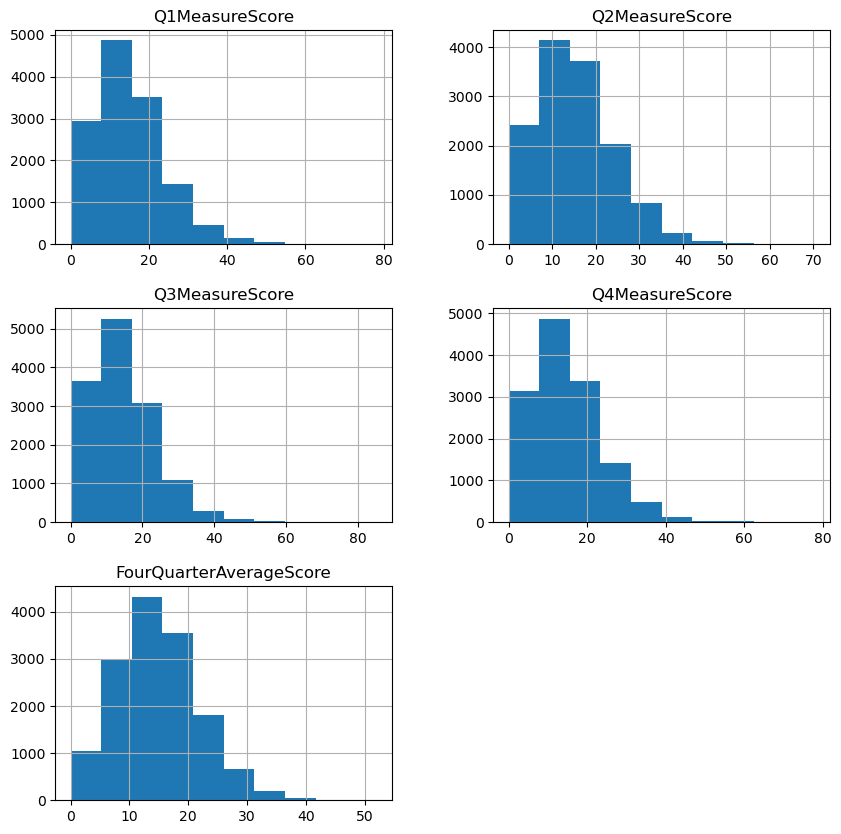

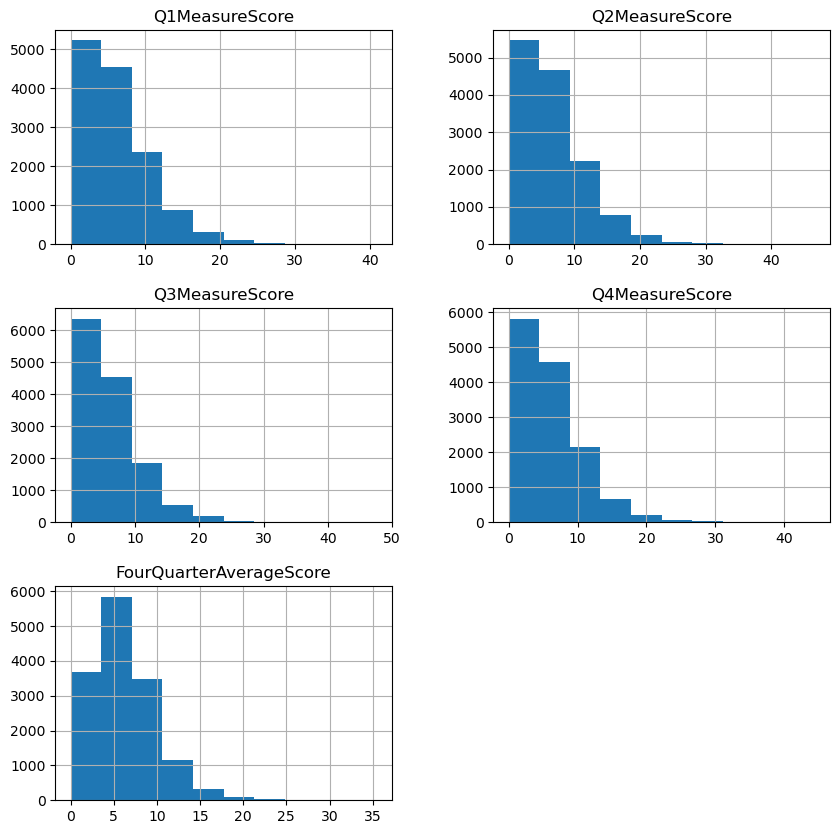

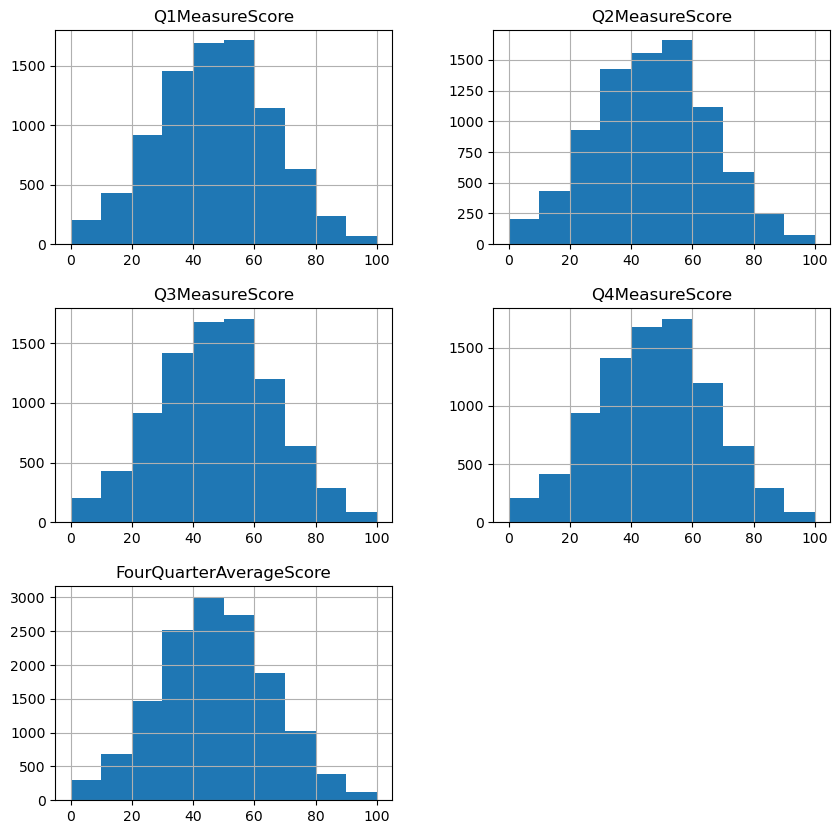

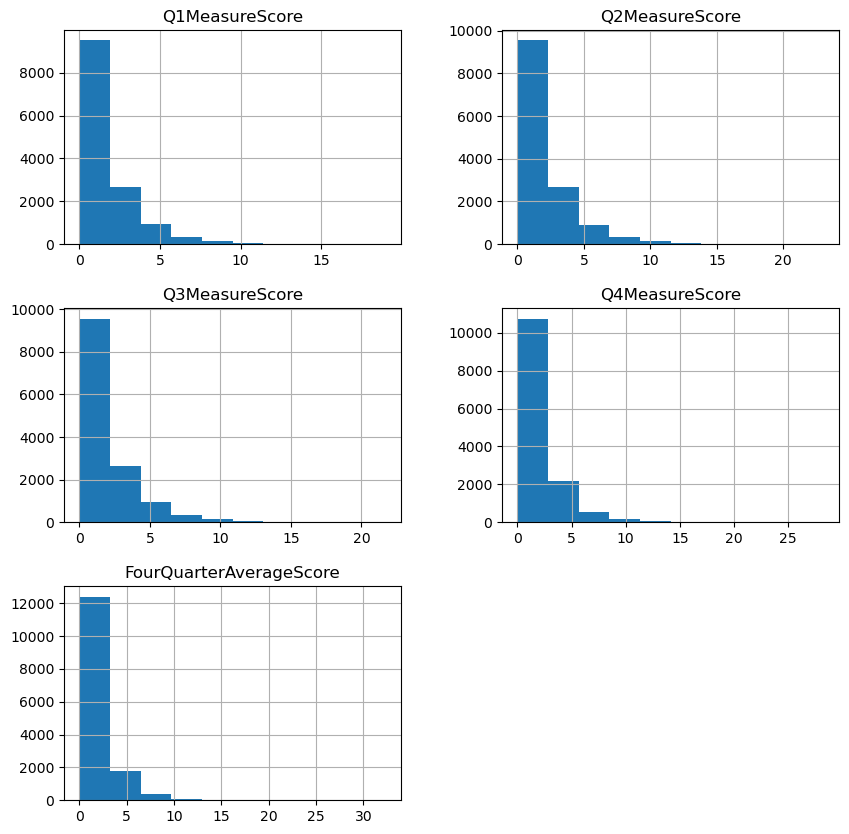

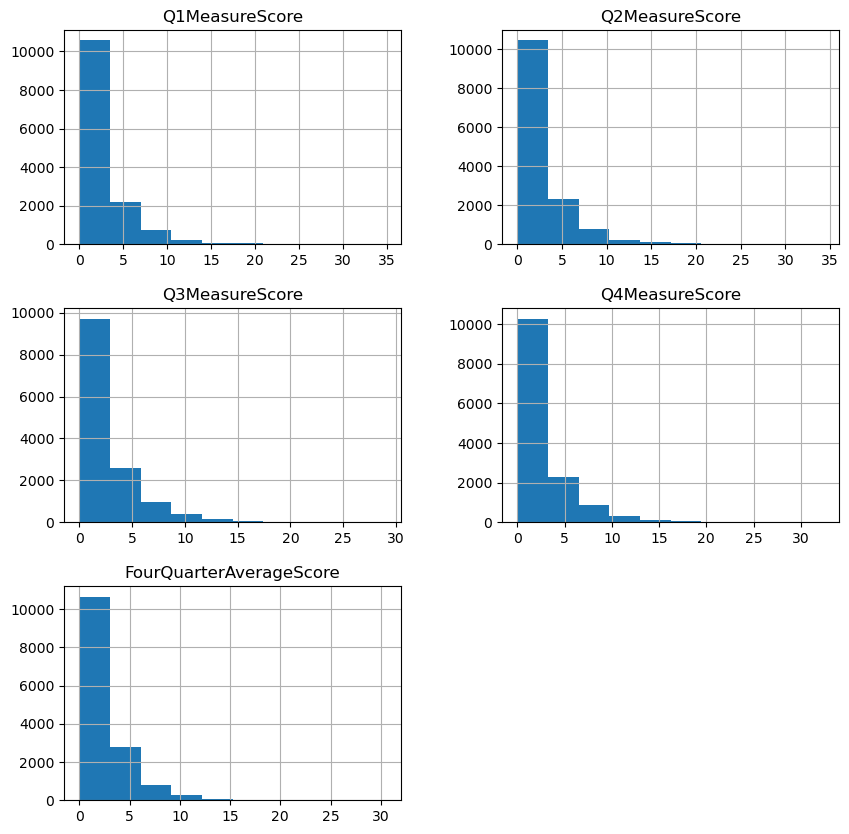

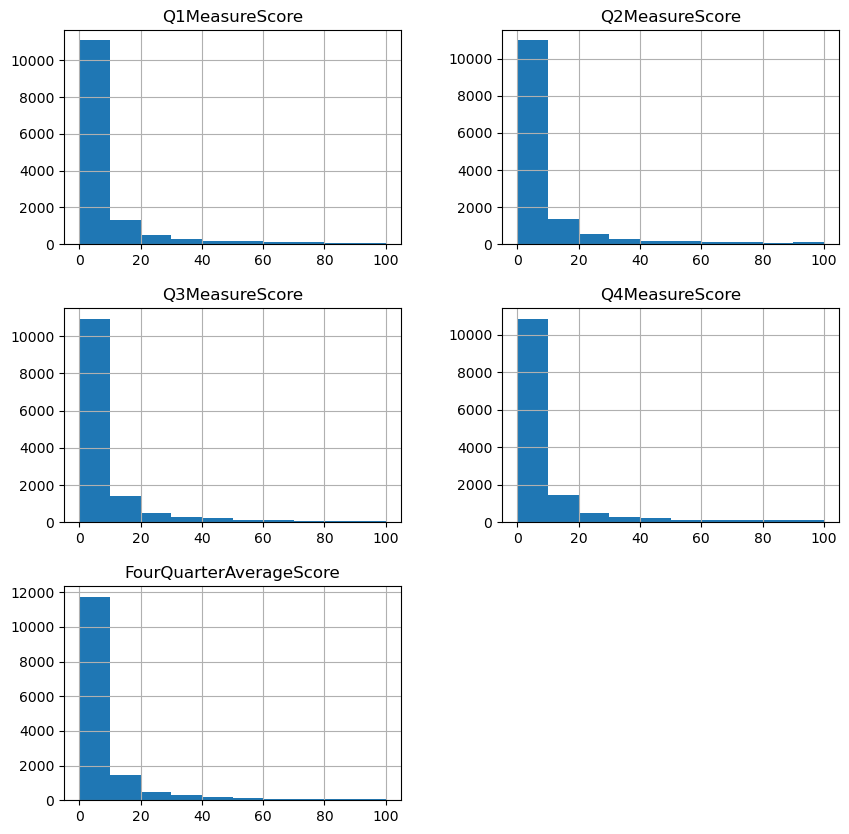

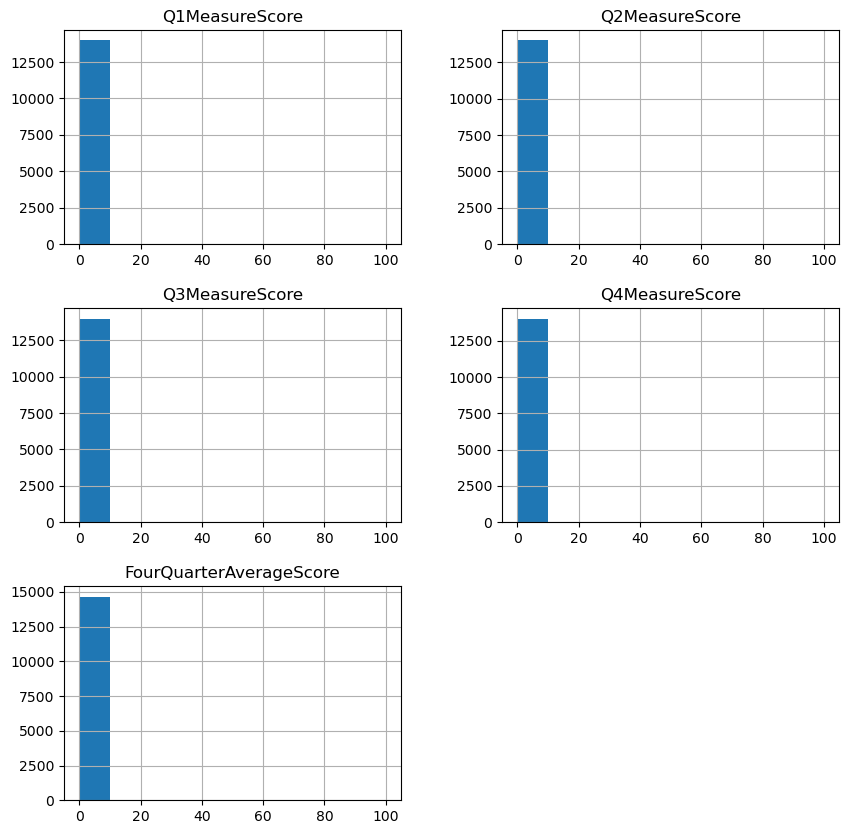

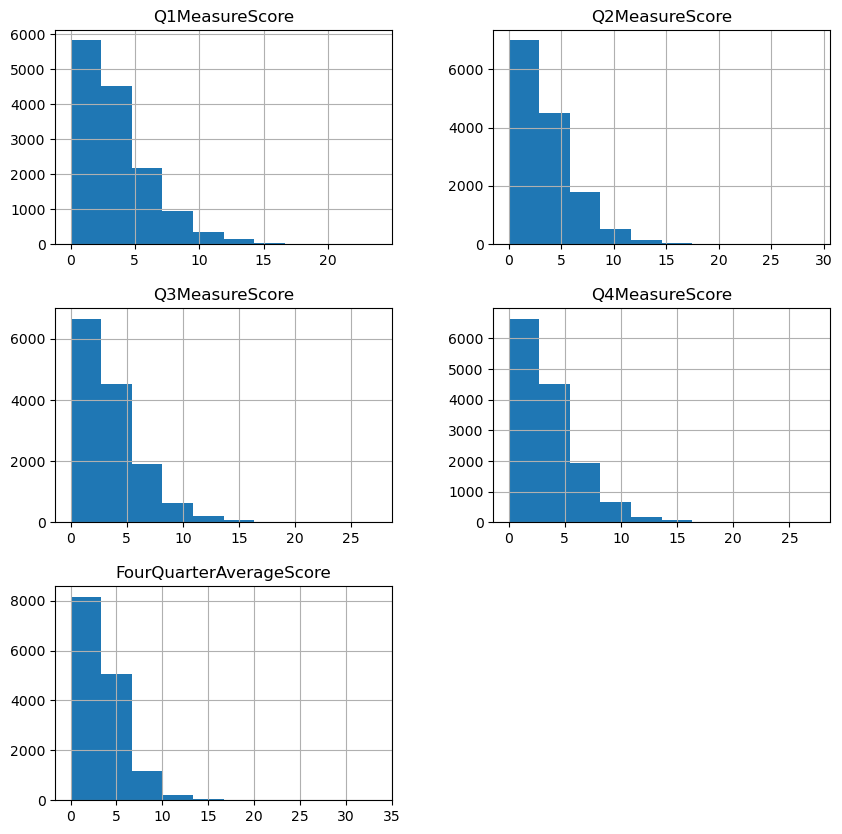

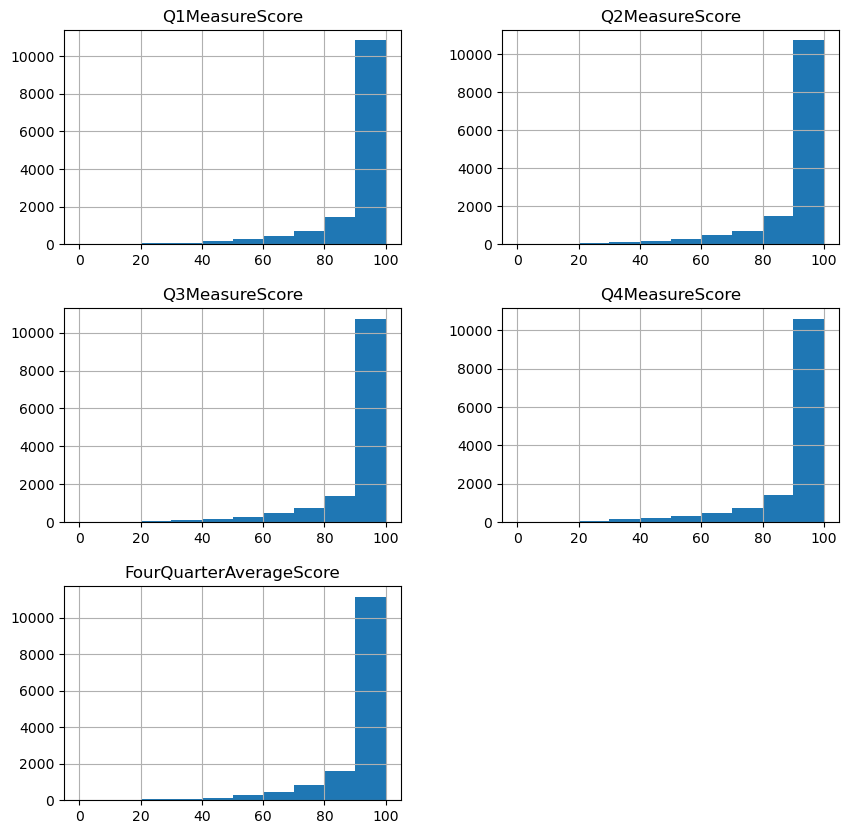

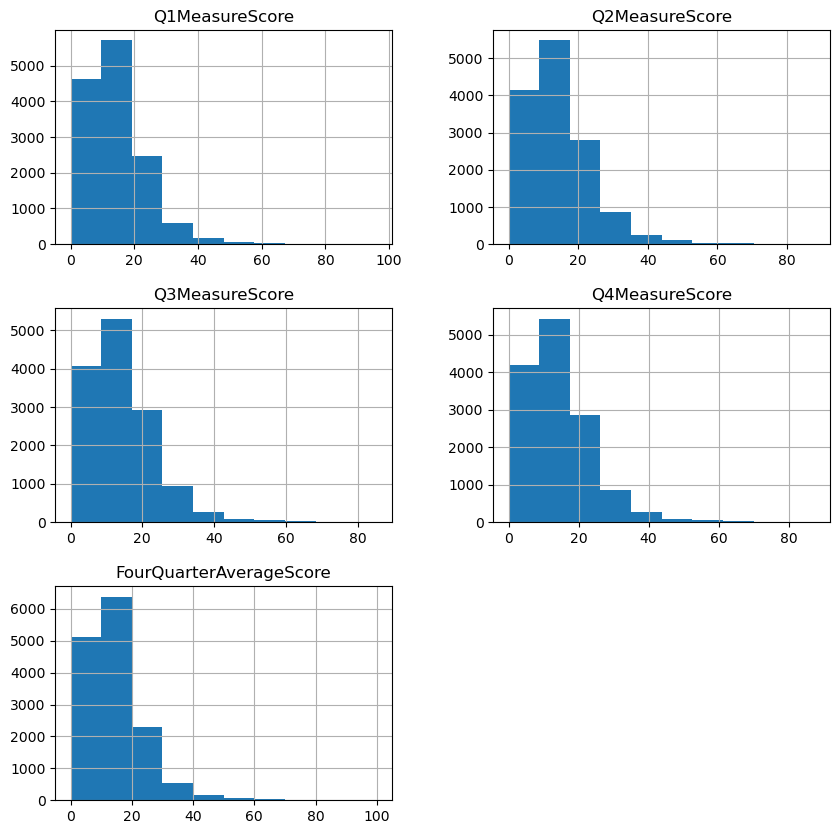

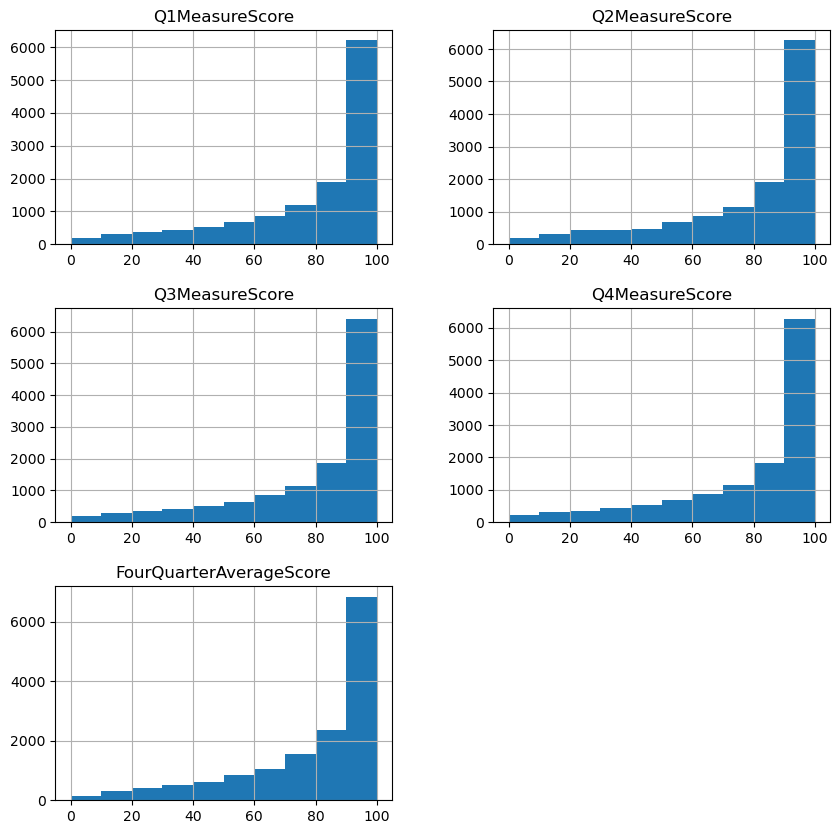

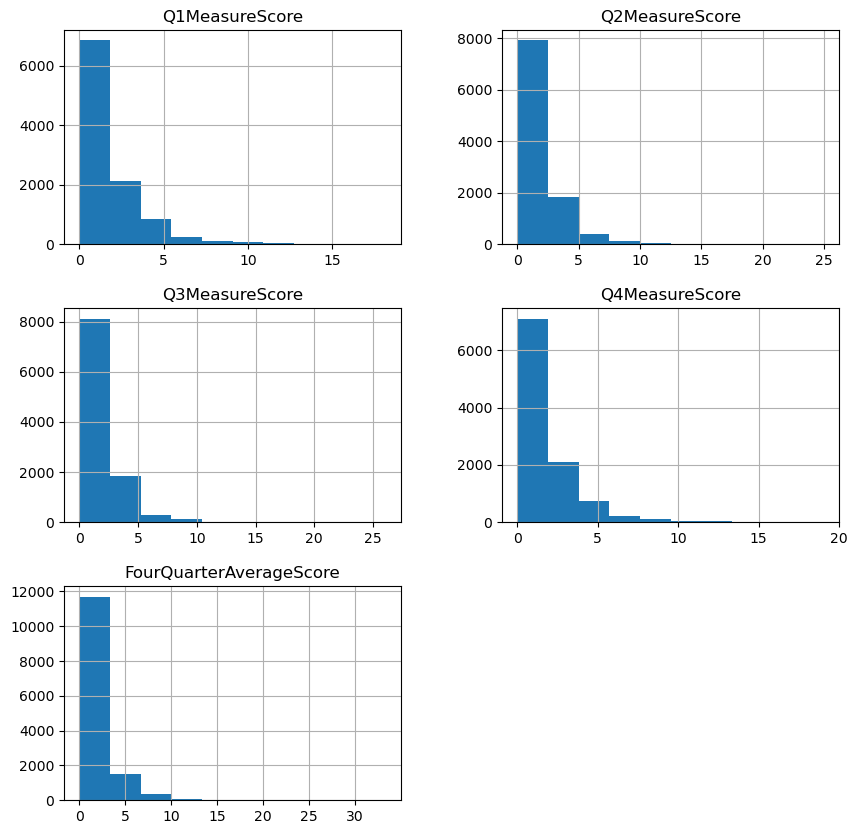

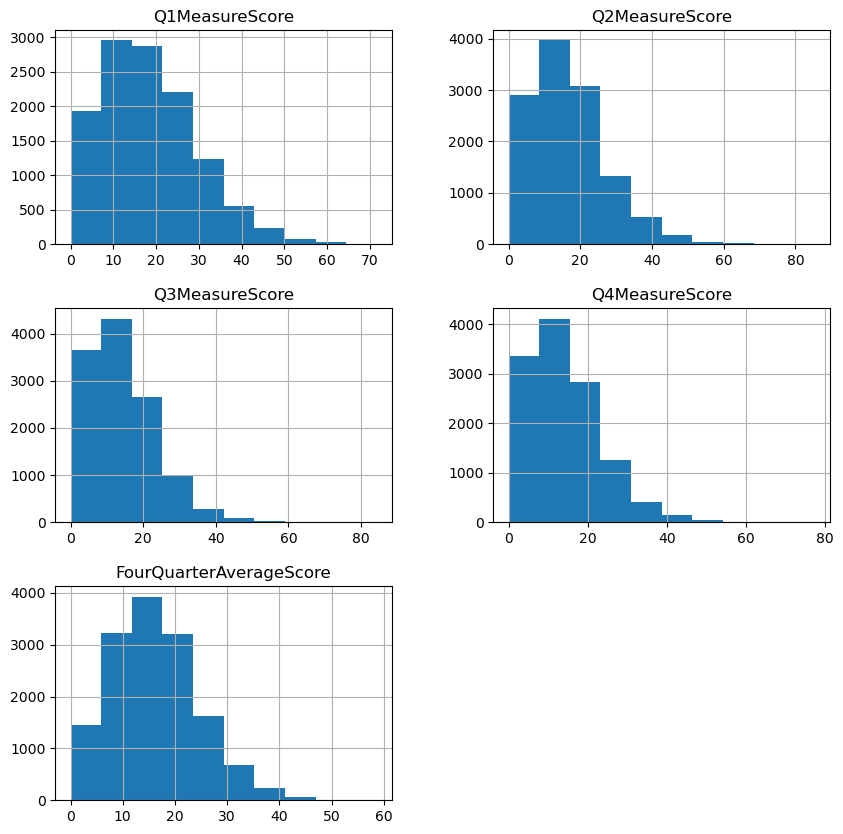

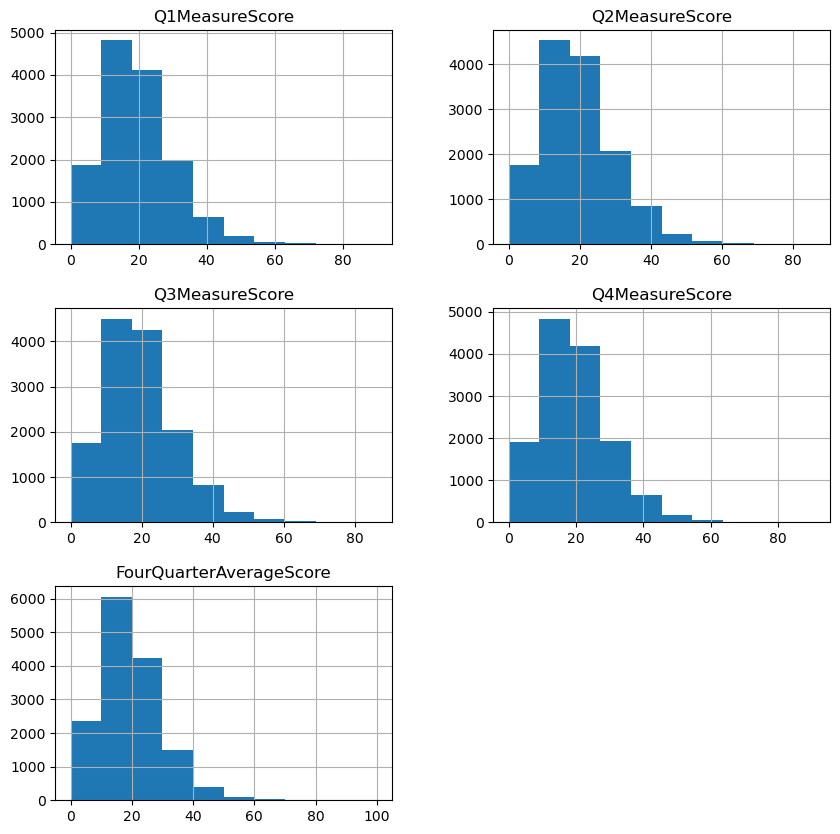

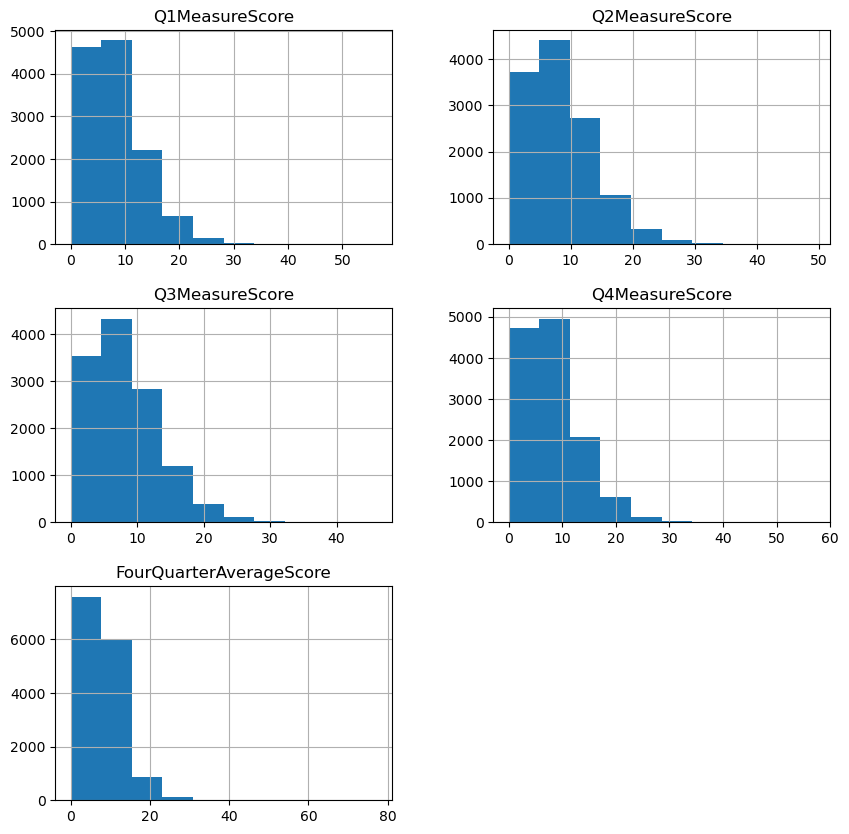

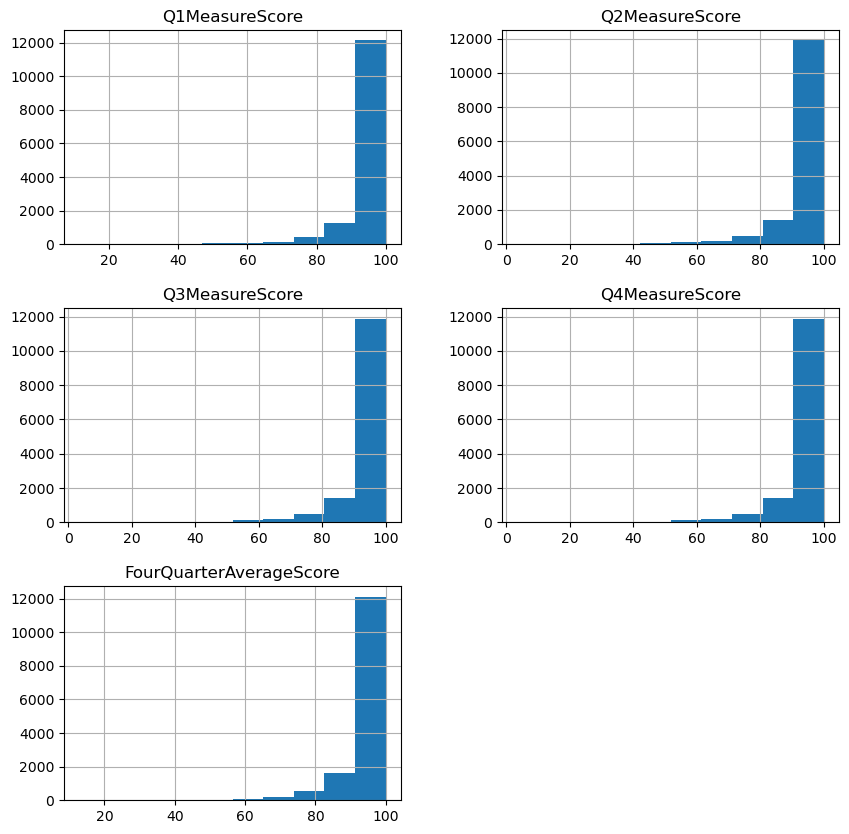

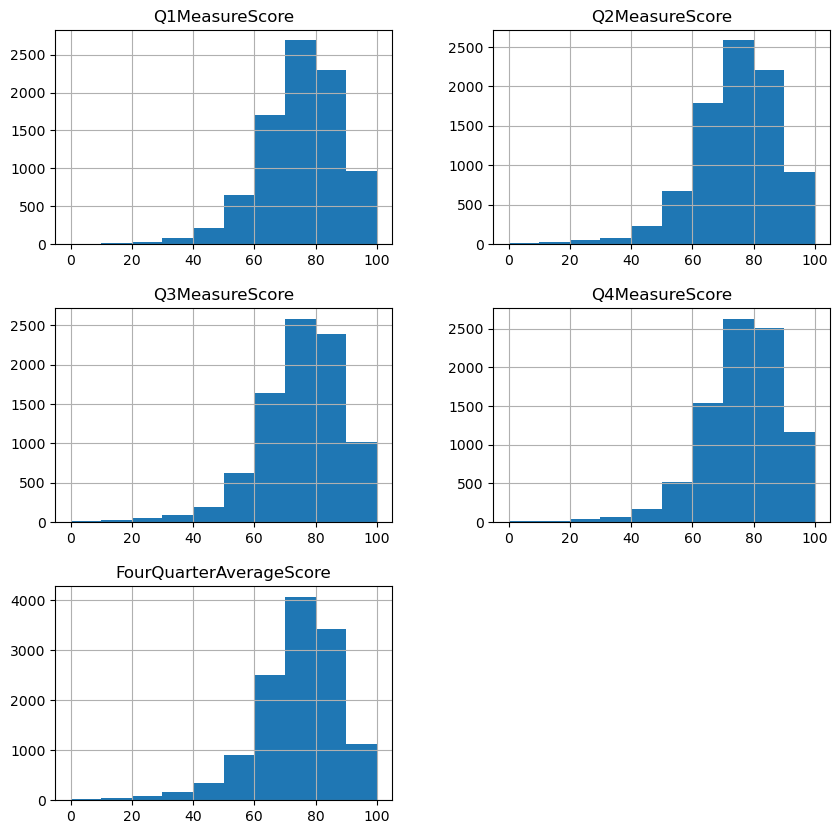

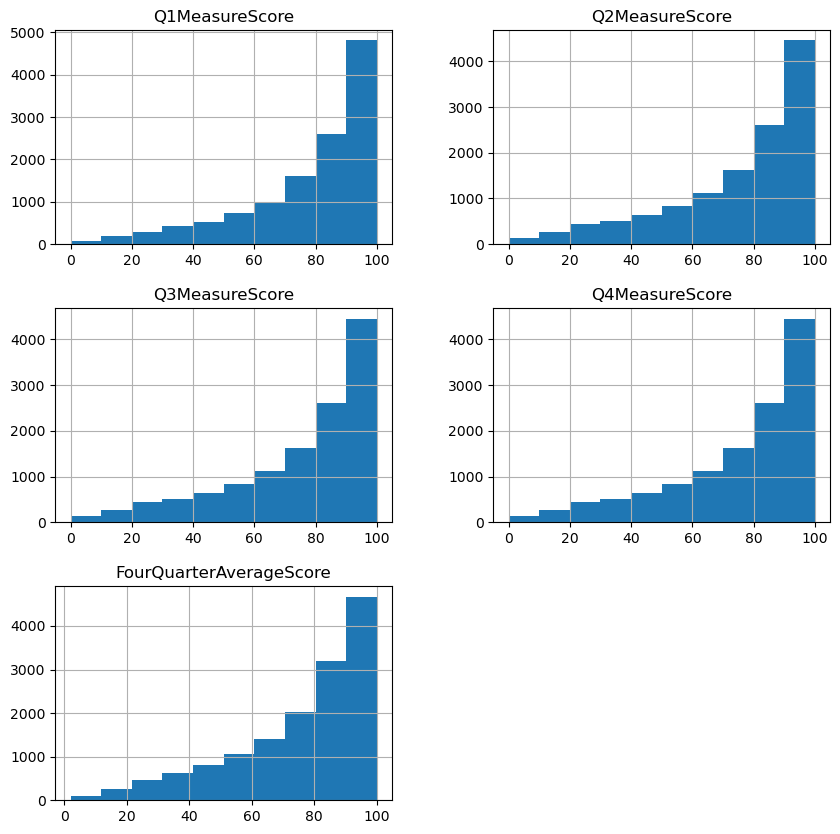

In [35]:
residentAssessmentDF[["Q1MeasureScore", "Q2MeasureScore", "Q3MeasureScore", "Q4MeasureScore", "FourQuarterAverageScore"]].groupby(residentAssessmentDF.MeasureCode).hist(figsize = (10,10))

In [36]:
residentAssessmentDF[["Q1MeasureScore", "Q2MeasureScore", "Q3MeasureScore", "Q4MeasureScore", "FourQuarterAverageScore"]].groupby(residentAssessmentDF.MeasureCode).count()

,Q1MeasureScore,Q2MeasureScore,Q3MeasureScore,Q4MeasureScore,FourQuarterAverageScore
MeasureCode,,,,,
401,13416,13461,13460,13489,14595
404,13481,13494,13514,13519,14632
405,8502,8228,8545,8638,14153
406,13697,13717,13732,13770,14657
407,13903,13915,13922,13948,14672
408,13823,13829,13842,13871,14667
409,14006,14023,14019,14056,14687
410,14011,14028,14024,14059,14688
415,14011,14028,14024,14059,14688


We once again have different rows for each metric, 18 metrics in total, with 4 quarters of scores in each row. Overall the distributions of the scores look reasonable but we notably have inconsistent numbers of entries across each quarter. To help account for this we will report each quarter measurement individually instead of relying on the average score, so we can know where we have missing values.

We will end up with 18x4 columns, one for each metric for each quarter, much in the way the above scores were aggregated

In [37]:
columnLabels = ["FederalProviderNumber", "Q1MeasureScore", "Q2MeasureScore", "Q3MeasureScore", "Q4MeasureScore"]
newColumnLabels = ["Q1MeasureScore", "Q2MeasureScore", "Q3MeasureScore", "Q4MeasureScore"]
codes = residentAssessmentDF.MeasureCode.unique()

codeList = list(range(len(codes)))
for index in range(len(codes)):
    codeList[index] = residentAssessmentDF[columnLabels].loc[residentAssessmentDF["MeasureCode"] == codes[index]]
    codeList[index].columns = ["FederalProviderNumber"] + [label + str(codes[index]) for label in newColumnLabels]
    codeList[index].set_index("FederalProviderNumber", inplace = True)
    
residentialAssessmentCodes = (pd.DataFrame(residentAssessmentDF.FederalProviderNumber.unique(), columns = {"FederalProviderNumber"})).set_index("FederalProviderNumber")
residentialAssessmentCodes = residentialAssessmentCodes.join(codeList)

array([[<AxesSubplot:title={'center':'Q1MeasureScore401'}>,
        <AxesSubplot:title={'center':'Q2MeasureScore401'}>,
        <AxesSubplot:title={'center':'Q3MeasureScore401'}>,
        <AxesSubplot:title={'center':'Q4MeasureScore401'}>,
        <AxesSubplot:title={'center':'Q1MeasureScore404'}>,
        <AxesSubplot:title={'center':'Q2MeasureScore404'}>,
        <AxesSubplot:title={'center':'Q3MeasureScore404'}>,
        <AxesSubplot:title={'center':'Q4MeasureScore404'}>],
       [<AxesSubplot:title={'center':'Q1MeasureScore405'}>,
        <AxesSubplot:title={'center':'Q2MeasureScore405'}>,
        <AxesSubplot:title={'center':'Q3MeasureScore405'}>,
        <AxesSubplot:title={'center':'Q4MeasureScore405'}>,
        <AxesSubplot:title={'center':'Q1MeasureScore406'}>,
        <AxesSubplot:title={'center':'Q2MeasureScore406'}>,
        <AxesSubplot:title={'center':'Q3MeasureScore406'}>,
        <AxesSubplot:title={'center':'Q4MeasureScore406'}>],
       [<AxesSubplot:title={'center':'

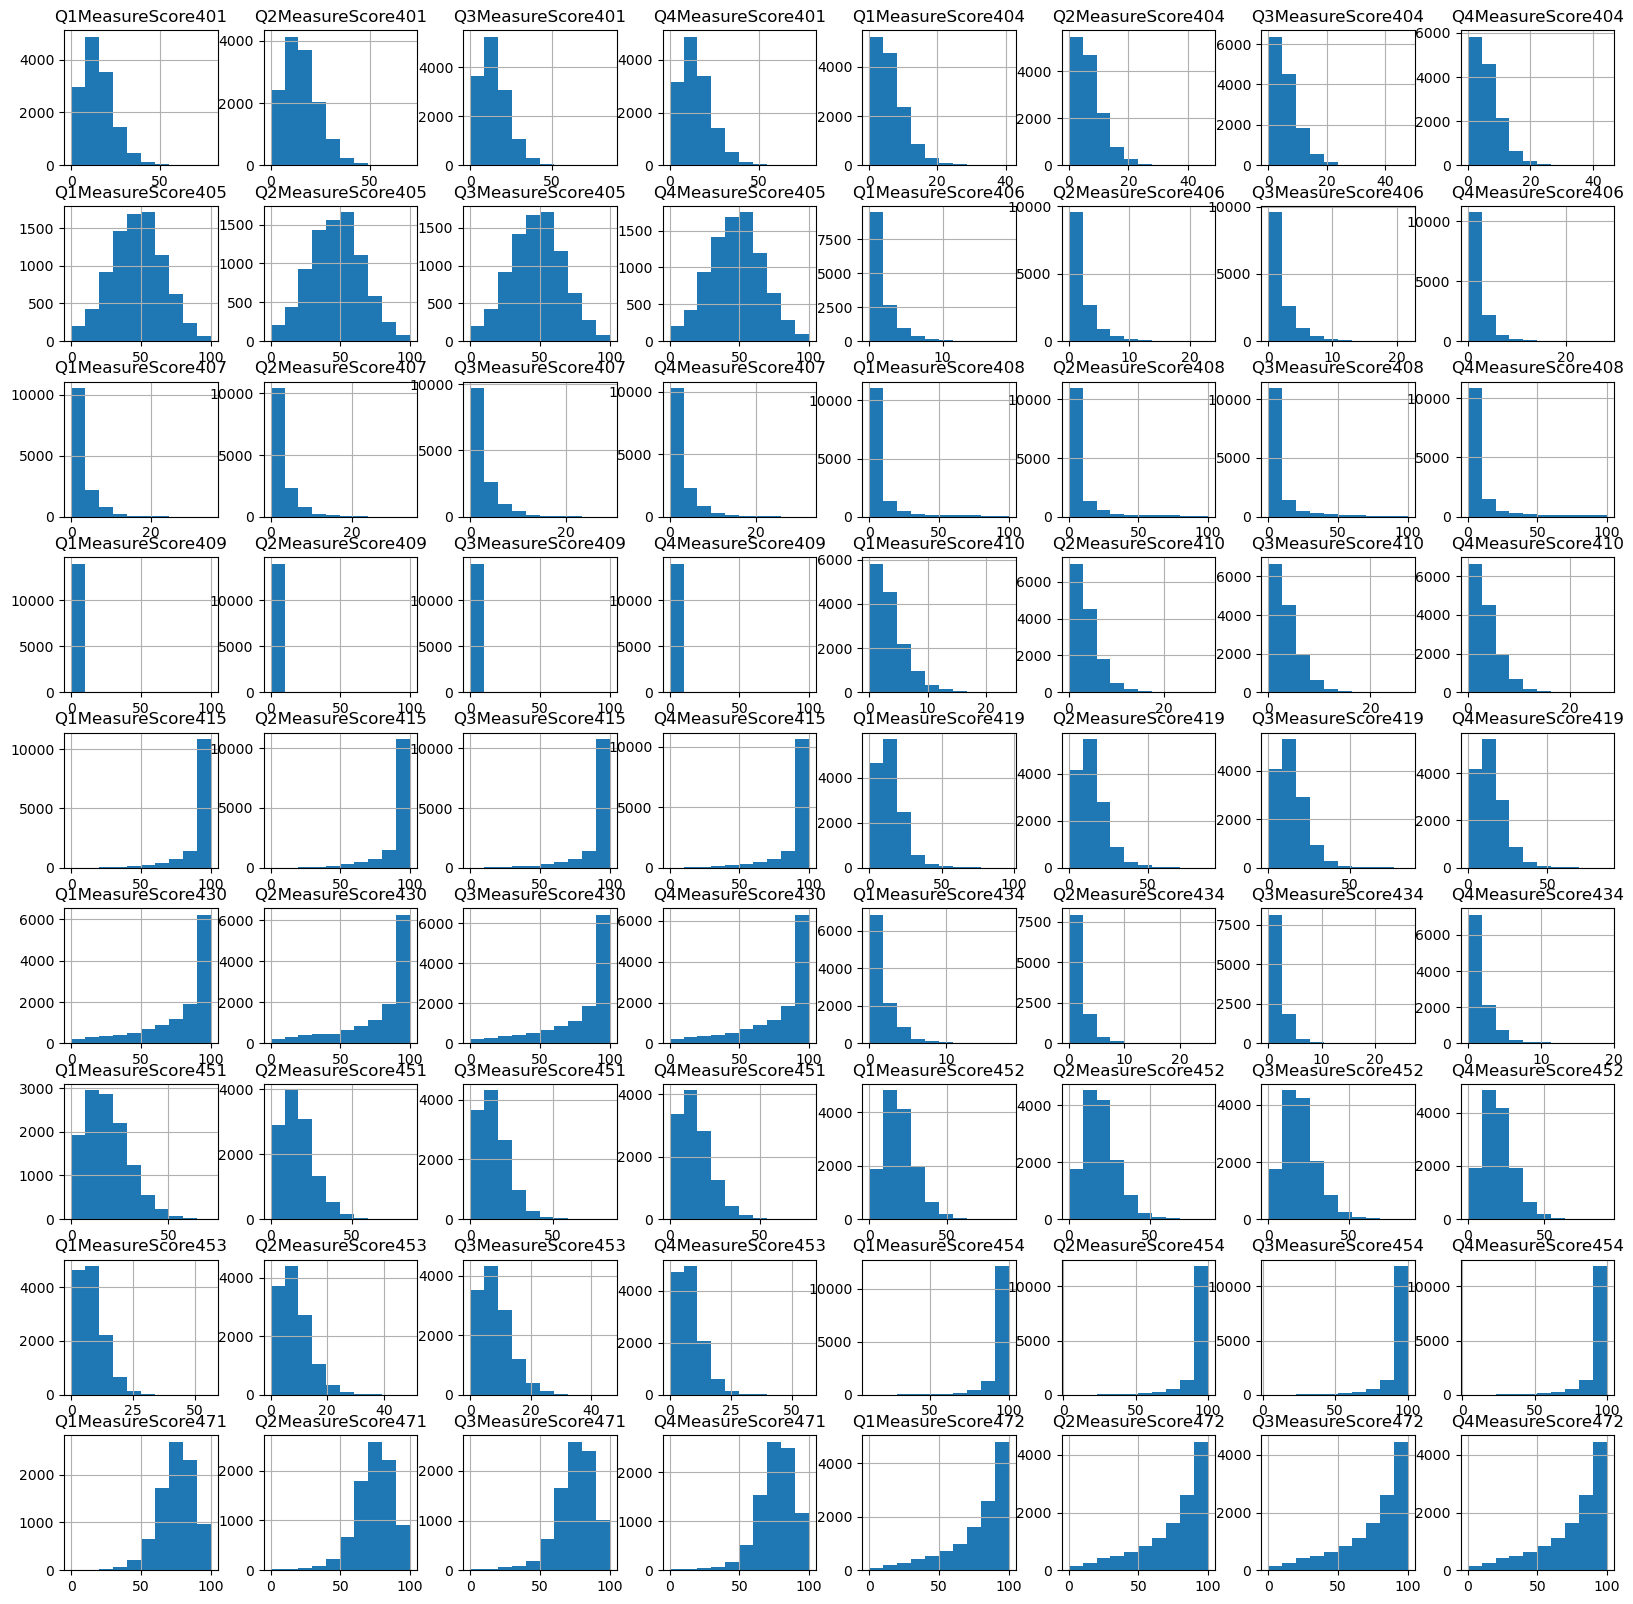

In [38]:
#data looks the same before and after
residentialAssessmentCodes.hist(figsize = (20,20))

Now all we have left is to seperate out our target from our last dataset. We have two targets that we will be seperating out, MeasureCode S_005_02_DTC_COMP_PERF and MeasureCode S_039_01_HAI_COMP_PERF.

In [39]:
careMeasuresDF.head()

,CMSCertificationNumber(CCN),FacilityName,AddressLine1,City,State,ZipCode,CountyName,PhoneNumber,CMSRegion,MeasureCode,Score,Footnote,StartDate,EndDate,MeasureDateRange,LOCATION1
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,Franklin,(256)332-4110,4,S_001_03_DENOMINATOR,64,NaN,04/01/2021,03/31/2022,NaN,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653"
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,Franklin,(256)332-4110,4,S_001_03_NUMERATOR,62,NaN,04/01/2021,03/31/2022,NaN,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653"
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,Franklin,(256)332-4110,4,S_001_03_OBS_RATE,96.9,NaN,04/01/2021,03/31/2022,NaN,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653"
3,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,Franklin,(256)332-4110,4,S_004_01_PPR_PD_COMP_PERF,No Different than the National Rate,NaN,07/01/2019,06/30/2021,07/01/2019-12/31/2019; 07/01/2020-06/30/2021,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653"
4,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,Franklin,(256)332-4110,4,S_004_01_PPR_PD_OBS,2.90,NaN,07/01/2019,06/30/2021,07/01/2019-12/31/2019; 07/01/2020-06/30/2021,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653"


In [40]:
careScores = [0,0]
careScores[0] = careMeasuresDF[["CMSCertificationNumber(CCN)", "Score"]].loc[careMeasuresDF["MeasureCode"] == "S_005_02_DTC_COMP_PERF"]
careScores[1] = careMeasuresDF[["CMSCertificationNumber(CCN)", "Score"]].loc[careMeasuresDF["MeasureCode"] == "S_039_01_HAI_COMP_PERF"]
careScores[0].columns = ["FederalProviderNumber", "FacilityReadmissionScore"]
careScores[1].columns = ["FederalProviderNumber", "InfectionScore"]
careScores[0].set_index("FederalProviderNumber", inplace = True)
careScores[1].set_index("FederalProviderNumber", inplace = True)

careScoresDF = (pd.DataFrame(careMeasuresDF["CMSCertificationNumber(CCN)"].unique(), columns = {"FederalProviderNumber"})).set_index("FederalProviderNumber")
careScoresDF = careScoresDF.join(careScores)

Now our classes are grouped, we can see that despite having multiple years of data for each federal provider number, each score is reported only once for each Federal Provider number over those years, as such FederalProviderNumber alone is a unique identifier

This can be seen as joining our data to federal provider numbers alone produces no lost information: value counts from above:
>careMeasuresDF.loc[careMeasuresDF["MeasureCode"] == "S_005_02_DTC_COMP_PERF"].Score.value_counts()

No Different than the National Rate    7224  
Not Available                          5517  
Better than the National Rate          1787  
Worse than the National Rate            579  
Name: Score, dtype: int64

In [41]:
careScoresDF.FacilityReadmissionScore.value_counts()

No Different than the National Rate    7224
Not Available                          5517
Better than the National Rate          1787
Worse than the National Rate            579
Name: FacilityReadmissionScore, dtype: int64

and just to double check our other data, the output from our value counts above for:
>careMeasuresDF.loc[careMeasuresDF["MeasureCode"] == "S_039_01_HAI_COMP_PERF"].Score.value_counts()

No Different than the National Rate    11255  
Not Available                           3209  
Worse than the National Rate             473  
Better than the National Rate            170  
Name: Score, dtype: int64  

In [42]:
careScoresDF.InfectionScore.value_counts()

No Different than the National Rate    11255
Not Available                           3209
Worse than the National Rate             473
Better than the National Rate            170
Name: InfectionScore, dtype: int64

In [43]:
#and just to double check we have no duplicated indecies
print(careScoresDF.index.nunique())
print(careScoresDF.shape)

15107
(15107, 2)


Now we have our data in 5 different data frames:  
citationsCounts, penaltyCounts,  medicareCodes, residentialAssessmentCodes, and careScoresDF  
As the last three have the same number of rows, they can be joined, the first two however have multiple years of data for each index, which must be combined into one somehow

In [44]:
print(citationsCounts.shape)
print(penaltyCounts.shape)
print(medicareCodes.shape)
print(residentialAssessmentCodes.shape)
print(careScoresDF.shape)

(15003, 5)
(10876, 2)
(15107, 8)
(15107, 72)
(15107, 2)


In [45]:
nursingHomeData = careScoresDF.join([residentialAssessmentCodes, medicareCodes, penaltyCounts, citationsCounts], how="outer")

In [46]:
nursingHomeData.shape

(15107, 89)

In [47]:
nursingHomeData.isnull().any(axis=1).sum()

14683

In [48]:
nursingHomeData.isnull().sum()

FacilityReadmissionScore                   0
InfectionScore                             0
Q1MeasureScore401                       1691
Q2MeasureScore401                       1646
Q3MeasureScore401                       1647
                                        ... 
StandardDeficiency                       104
ComplaintDeficiency                      104
InfectionControlInspectionDeficiency     104
CitationunderIDR                         104
CitationunderIIDR                        104
Length: 89, dtype: int64

With that we know our data has plenty of null values, but at it is all in one place, we can save it and move on to data preprocessing. Below is this process all in one place.

In [49]:
#perform aggregating and joining of data as above
#copied into a python file so it can be imported
#this is the initial process, updates may be made in the dataPrep.py file that are not from this process
def prepJoinedNursingHomeData():
    #imports
    import pandas as pd
    import numpy as np
    
    #load datasets, remove spaces from column names
    citationsDF = pd.read_csv('datasets/NH_HealthCitations_Jan2023.csv', dtype = {'Federal Provider Number' : str})
    citationsDF.columns = citationsDF.columns.str.replace(' ', '')
    penaltysDF = pd.read_csv('datasets/NH_Penalties_Jan2023.csv')
    penaltysDF.columns = penaltysDF.columns.str.replace(' ', '')
    medicareClaimsDF = pd.read_csv('datasets/NH_QualityMsr_Claims_Jan2023.csv')
    medicareClaimsDF.columns = medicareClaimsDF.columns.str.replace(' ', '')
    residentAssessmentDF = pd.read_csv('datasets/NH_QualityMsr_MDS_Jan2023.csv', dtype = {'Federal Provider Number': str})
    residentAssessmentDF.columns = residentAssessmentDF.columns.str.replace(' ', '')
    careMeasuresDF = pd.read_csv('datasets/Skilled_Nursing_Facility_Quality_Reporting_Program_Provider_Data_Jan2023.csv' , dtype = {'CMS Certification Number (CCN)': str})
    careMeasuresDF.columns = careMeasuresDF.columns.str.replace(' ', '')

    #get count of citations by federal provider number
    citationCategories = ['StandardDeficiency', 'ComplaintDeficiency', 'InfectionControlInspectionDeficiency', 'CitationunderIDR', 'CitationunderIIDR']
    citationsDF[citationCategories] = citationsDF[citationCategories].astype(str).replace('N', np.NaN)
    citationsCounts = pd.DataFrame(citationsDF.groupby('FederalProviderNumber')[citationCategories].count())
    
    #get count of fines by federal provider number
    fineCounts = pd.DataFrame((penaltysDF.loc[penaltysDF["PenaltyType"] == "Fine"]).groupby("FederalProviderNumber")["PenaltyType"].count())
    paymentDenialCounts = pd.DataFrame((penaltysDF.loc[penaltysDF["PenaltyType"] == "Payment Denial"]).groupby("FederalProviderNumber")["PenaltyType"].count())
    fineCounts.rename(columns = {"PenaltyType": "fineCounts"}, inplace=True)
    paymentDenialCounts.rename(columns = {"PenaltyType": "paymentDenialCounts"}, inplace=True)
    penaltyCounts = fineCounts.join(paymentDenialCounts, how = "outer")

    #go from one row per evaluation metric to one column per metric by federal provider number
    columnLabels = ["FederalProviderNumber", "AdjustedScore", "ExpectedScore"]
    newColumnLabels = ["AdjustedScore", "ExpectedScore"]
    codes = medicareClaimsDF.MeasureCode.unique()
    codeList = [0,1,2,3]
    for index in range(len(codes)):
        codeList[index] = medicareClaimsDF[columnLabels].loc[medicareClaimsDF["MeasureCode"] == codes[index]]
        codeList[index].columns = ["FederalProviderNumber"] + [label + str(codes[index]) for label in newColumnLabels]
        codeList[index].set_index("FederalProviderNumber", inplace = True)
    
    #go from one row per evaluation metric to one column per metric by federal provider number
    medicareCodes = (pd.DataFrame(medicareClaimsDF.FederalProviderNumber.unique(), columns = {"FederalProviderNumber"})).set_index("FederalProviderNumber")
    medicareCodes = medicareCodes.join(codeList)
    columnLabels = ["FederalProviderNumber", "Q1MeasureScore", "Q2MeasureScore", "Q3MeasureScore", "Q4MeasureScore"]
    newColumnLabels = ["Q1MeasureScore", "Q2MeasureScore", "Q3MeasureScore", "Q4MeasureScore"]
    codes = residentAssessmentDF.MeasureCode.unique()
    codeList = list(range(len(codes)))
    for index in range(len(codes)):
        codeList[index] = residentAssessmentDF[columnLabels].loc[residentAssessmentDF["MeasureCode"] == codes[index]]
        codeList[index].columns = ["FederalProviderNumber"] + [label + str(codes[index]) for label in newColumnLabels]
        codeList[index].set_index("FederalProviderNumber", inplace = True)
    
    #go from one row per evaluation metric to one column per metric by federal provider number
    residentialAssessmentCodes = (pd.DataFrame(residentAssessmentDF.FederalProviderNumber.unique(), columns = {"FederalProviderNumber"})).set_index("FederalProviderNumber")
    residentialAssessmentCodes = residentialAssessmentCodes.join(codeList)
    careScores = [0,0]
    careScores[0] = careMeasuresDF[["CMSCertificationNumber(CCN)", "Score"]].loc[careMeasuresDF["MeasureCode"] == "S_005_02_DTC_COMP_PERF"]
    careScores[1] = careMeasuresDF[["CMSCertificationNumber(CCN)", "Score"]].loc[careMeasuresDF["MeasureCode"] == "S_039_01_HAI_COMP_PERF"]
    careScores[0].columns = ["FederalProviderNumber", "FacilityReadmissionScore"]
    careScores[1].columns = ["FederalProviderNumber", "InfectionScore"]
    careScores[0].set_index("FederalProviderNumber", inplace = True)
    careScores[1].set_index("FederalProviderNumber", inplace = True)
    careScoresDF = (pd.DataFrame(careMeasuresDF["CMSCertificationNumber(CCN)"].unique(), columns = {"FederalProviderNumber"})).set_index("FederalProviderNumber")
    careScoresDF = careScoresDF.join(careScores)

    #join all the datasets and return
    nursingHomeData = careScoresDF.join([residentialAssessmentCodes, medicareCodes, penaltyCounts, citationsCounts], how="outer")
    return nursingHomeData

In [50]:
#check to see if our methods are equivalent
prepedNursingHomeData = prepJoinedNursingHomeData()
print(nursingHomeData.equals(prepedNursingHomeData))

True
